In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import matplotlib.pyplot as plt
import itertools
from matplotlib import pyplot
import sys
%matplotlib inline

def summarize_diagnostics(history, save_name='temp'):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.tight_layout()
    # save plot to file
    pyplot.savefig(save_name + '_plot.png')
    pyplot.show()
    pyplot.close()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1.keras.backend import clear_session
from tensorflow.compat.v1.keras.backend import get_session
import gc
# import tensorflow

# Reset Keras Session
def reset_keras(model):
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

# Dataset

In [6]:
DATASET_DIR = os.path.join('..', 'dataset')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test1')

IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
TEST_SIZE = 0.2
EPOCHS = 10
NUM_CATEGORIES = 2


## Load train dataset

In [8]:
images_list = os.listdir(TRAIN_DIR)
categories = []
for image_name in images_list:
    if 'cat' in image_name:
        categories.append('0')
    else:
        categories.append('1')

image_df = pd.DataFrame({
    'image_name': images_list,
    'category': categories
})

image_df

,image_name,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = datagen.flow_from_dataframe(
    image_df,
    directory=TRAIN_DIR,
    x_col='image_name',
    y_col='category',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=63,
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    image_df,
    directory=TRAIN_DIR,
    x_col='image_name',
    y_col='category',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=63,
    subset='validation'
)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# Model structure

In [19]:
def get_model():
    model = tf.keras.models.Sequential()
        
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(units=512, activation='relu'))
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    # model.summary()

    return model

In [12]:
# Disable GPU
# tf.config.set_visible_devices([], 'GPU')

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


# Training

## Load pre-trained model or Initialize new model

### Load pretrained-model

In [ ]:
MODEL_PATH = 'CNN_0.81.h5'
model = tf.keras.models.load_model(MODEL_PATH)
# model.compile(
#     optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=['accuracy']
# )

### Initialize new model

In [20]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        3

## Train model

Epoch 1/50
625/625 [==============================] - 61s 96ms/step - loss: 0.6617 - accuracy: 0.6219 - val_loss: 0.8525 - val_accuracy: 0.0000e+00
Epoch 2/50
625/625 [==============================] - 57s 91ms/step - loss: 0.6537 - accuracy: 0.6252 - val_loss: 0.7997 - val_accuracy: 0.0000e+00
Epoch 3/50
625/625 [==============================] - 60s 96ms/step - loss: 0.6455 - accuracy: 0.6291 - val_loss: 0.8644 - val_accuracy: 0.0473
Epoch 4/50
625/625 [==============================] - 56s 89ms/step - loss: 0.6358 - accuracy: 0.6435 - val_loss: 0.8001 - val_accuracy: 0.2933
Epoch 5/50
625/625 [==============================] - 61s 97ms/step - loss: 0.6295 - accuracy: 0.6511 - val_loss: 0.7655 - val_accuracy: 0.4251
Epoch 6/50
625/625 [==============================] - 58s 92ms/step - loss: 0.6203 - accuracy: 0.6604 - val_loss: 0.7402 - val_accuracy: 0.5094
Epoch 7/50
625/625 [==============================] - 63s 100ms/step - loss: 0.6146 - accuracy: 0.6667 - val_loss: 0.6829 - val_

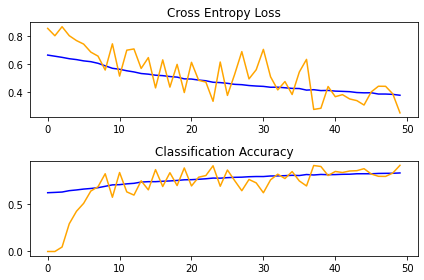

5408


In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

# reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.0001)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 32,
    epochs = 50,
    callbacks=[early_stopping]
)

model.save('temp.h5')
summarize_diagnostics(history, 'temp')
reset_keras(model)

In [18]:
CONTINUE_TRAINING_MODEL = 'temp.h5'
model = tf.keras.models.load_model(CONTINUE_TRAINING_MODEL)

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 32,
    epochs = 10,
    callbacks=[early_stopping]
)

model.save('temp2.h5')
summarize_diagnostics(history, 'temp2')
reset_keras(model)

Epoch 1/10
625/625 [==============================] - 60s 96ms/step - loss: 0.3389 - accuracy: 0.8504 - val_loss: 0.3512 - val_accuracy: 0.8472
Epoch 2/10
625/625 [==============================] - 60s 97ms/step - loss: 0.3408 - accuracy: 0.8494 - val_loss: 0.3657 - val_accuracy: 0.8417
Epoch 3/10
450/625 [====================>.........] - ETA: 12s - loss: 0.3360 - accuracy: 0.8482- ETA: 24s 

KeyboardInterrupt: 

# Evaluation

In [20]:
model = tf.keras.models.load_model('temp2.h5')

In [33]:
X_test = np.load(os.path.join(DATASET_DIR, 'train_images.npy'))
y_test = np.load(os.path.join(DATASET_DIR, 'train_labels.npy'))

In [34]:
y_pred = model.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71     12500
           1       0.71      0.72      0.71     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000



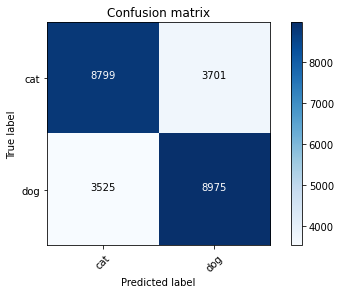

In [35]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['cat', 'dog'])

# Demo

In [8]:
demo_img = cv2.imread('demo.jpg')
demo_img = cv2.resize(demo_img, IMG_SIZE)

CONTINUE_TRAINING_MODEL = 'CNN_0.88.h5'
model = tf.keras.models.load_model(CONTINUE_TRAINING_MODEL)

pred = model.predict(np.array([demo_img]))
pred = tf.argmax(pred, axis=1)[0]
print(pred)

tf.Tensor(1, shape=(), dtype=int64)
